In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import random
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Input, Dropout
import tensorflow as tf
import math
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, classification_report, roc_auc_score, average_precision_score, confusion_matrix, accuracy_score
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor
from google.colab import drive 

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터 로딩
df = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/time_series_iter.csv')
# df = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/time_series_knn_5.csv')
# df = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/time_series_knn_20.csv')
#del df["Unnamed: 0.1"]
df = df[['hadm_id', 'sbp', 'dbp', 'resp', 'hr', 'temp_c', 'crystalloid_bolus', 'rbc', 'urine', 'event']]
st = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/static_df.csv')
df = st.iloc[:,:3].merge(df)

In [ ]:
df

,hadm_id,age,gender,sbp,dbp,resp,hr,temp_c,crystalloid_bolus,rbc,urine,event
0,100001,35,1,111.4,59.8,26.2,77.65,36.677750,0.0,0.0,0.0,0.0
1,100001,35,1,111.4,59.8,26.2,77.65,36.677750,0.0,0.0,0.0,0.0
2,100001,35,1,111.4,59.8,26.2,77.65,36.677750,0.0,0.0,0.0,0.0
3,100001,35,1,111.4,59.8,26.2,77.65,36.677750,0.0,0.0,0.0,0.0
4,100001,35,1,111.4,59.8,26.2,77.65,36.677750,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33067,199780,52,1,99.0,61.0,20.0,77.00,36.733320,0.0,0.0,250.0,0.0
33068,199780,52,1,100.0,56.0,20.0,75.00,36.666680,0.0,0.0,0.0,0.0
33069,199780,52,1,113.0,77.0,20.0,88.00,36.494430,0.0,0.0,0.0,0.0
33070,199780,52,1,103.0,55.0,16.0,73.00,37.222198,0.0,0.0,0.0,0.0


In [5]:
# hadm_id 중복없이 리스트로 뽑고, df의 hadm_id에 해당하는 column의 데이터(프레임)를 x에 numpy array로 저장 
# hadm_id가 중복되면 (case 2개 이상), 한 hadm_id에 numpy array가 24 단위로 증가된 것만 남고, 나머지는 제거됨   

hadm_id =list(set(df['hadm_id'].tolist()))
column_name = df.columns[1:]
x = [df[df['hadm_id']==i][column_name].to_numpy() for i in hadm_id]


In [6]:
# 입력 데이터 만들기 
# x를 받아서 array가 48인 것은 event값에 따라 나누고, 24인 것과 최종 final_x, final_y로 지정

def data_split(np_array_list):
  final_x, final_y = [], []
  for np_array in np_array_list:
    if len(np_array) == 48:
      final_x.append(np_array[np.where(np_array[:, -1]==0)][:, :-1])
      final_y.append(0)
      final_x.append(np_array[np.where(np_array[:, -1]==1)][:, :-1])
      final_y.append(1)
    else:
      label = np_array[0, -1]
      final_x.append(np_array[:, :-1])
      final_y.append(label)

  return np.array(final_x), np.array(final_y)

In [7]:
final_x, final_y = data_split(x)
print("x shape:", final_x.shape, "y shape:", final_y.shape)

x shape: (1378, 24, 10) y shape: (1378,)


In [20]:
# train / test set 나누기

x_train, x_test, y_train, y_test = train_test_split(final_x, final_y, random_state=200, test_size=0.3, shuffle=True) 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(964, 24, 10)
(414, 24, 10)
(964,)
(414,)


In [21]:
# 모델 구성 

ag_model = Sequential()
ag_model.add(GRU(64, input_shape=(final_x.shape[1],10))),
ag_model.add(Dropout(0.5)),
ag_model.add(Dense(125, activation='relu')),
ag_model.add(Dense(1, activation='sigmoid'))

ag_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                14592     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 125)               8125      
                                                                 
 dense_3 (Dense)             (None, 1)                 126       
                                                                 
Total params: 22,843
Trainable params: 22,843
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 학습
ag_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

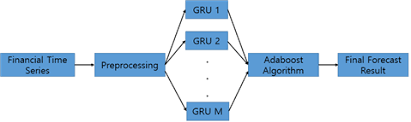

In [23]:
#!pip install scikeras

In [24]:
# Adaboost
from scikeras.wrappers import KerasRegressor

GRU_Predictors = KerasRegressor(build_fn=lambda:ag_model, epochs=100, batch_size=20)
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=50, random_state=101)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  after removing the cwd from sys.path.


In [25]:
# Fitting

history = final_model.fit(x_train, y_train)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
49/49 [==============================] - 1s 12ms/step - loss: 0.8101 - accuracy: 0.6566
Epoch 2/100
49/49 [==============================] - 1s 12ms/step - loss: 0.6523 - accuracy: 0.6162
Epoch 3/100
49/49 [==============================] - 1s 11ms/step - loss: 0.6348 - accuracy: 0.6546
Epoch 4/100
49/49 [==============================] - 1s 12ms/step - loss: 0.6454 - accuracy: 0.6183
Epoch 5/100
49/49 [==============================] - 1s 11ms/step - loss: 0.6533 - accuracy: 0.6162
Epoch 6/100
49/49 [==============================] - 1s 11ms/step - loss: 0.6116 - accuracy: 0.6473
Epoch 7/100
49/49 [==============================] - 1s 12ms/step - loss: 0.5861 - accuracy: 0.6660
Epoch 8/100
49/49 [==============================] - 1s 12ms/step - loss: 0.5729 - accuracy: 0.6680
Epoch 9/100
49/49 [==============================] - 1s 12ms/step - loss: 0.5528 - accuracy: 0.6815
Epoch 10/100
49/49 [==============================] - 1s 12ms/step - loss: 0

In [26]:
# 모델 평가 

print('TRAIN_SCORE: ', final_model.score(x_train, y_train))
print('TEST_SCORE: ', final_model.score(x_test, y_test))
y_pred = (final_model.predict(x_test) > 0.5).astype("int32")
print('ACCURACY_SCORE: ', accuracy_score(y_test, y_pred))

TRAIN_SCORE:  0.14003033726056047
TEST_SCORE:  -0.23108582275368872
ACCURACY_SCORE:  0.6038647342995169


In [27]:
# 모델 평가

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='skyblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    

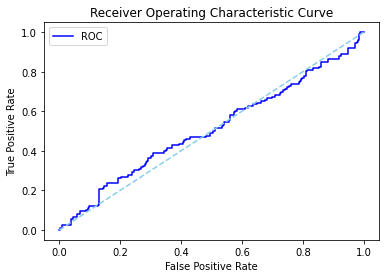

In [28]:
y_prob = final_model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plot_roc_curve(fpr, tpr)

In [29]:
print('AUC: %.4f' % roc_auc_score(y_test, final_model.predict(x_test)))

AUC: 0.5077


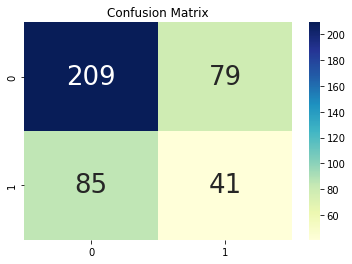

In [30]:
cm = confusion_matrix(y_test,y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='all')
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", cbar=True, annot_kws={"size": 26})

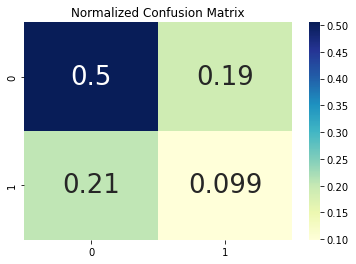

In [31]:
plt.title("Normalized Confusion Matrix")
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", cbar=True, annot_kws={"size": 26})